[@LorenaABarba](https://twitter.com/LorenaABarba)

##### Version 0.2 -- March 2014

# Source & Sink in a Freestream

You have reached the second notebook of the [*AeroPython*](https://github.com/barbagroup/AeroPython) series. Are you ready? Did you diligently study the first notebook and write your own version of the Python code to visualize a [Source & Sink](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/01_Lesson01_sourceSink.ipynb)? 

These notebooks are designed to build from each other, so don't skip any! With each one, you'll learn more Aerodynamics and more Python. In this notebook, you will build a solution of potential flow by adding a source, a sink, and a uniform free stream. Why? Because we can! Remember *superposition*? It's the pleasant property of (linear) potential flow, governed by Laplace's equation: $\nabla^2 \phi =0$.
    
This notebook will also show you how to modularize our code using function definitions. This will make things easier to manage.

## Let's get started

We start by importing the libraries that we will be using in this notebook (as before): the **NumPy** array library, the **Matplotlib** plotting library and the mathematical functions in the `math` module.

In [1]:
import numpy
import math
from matplotlib import pyplot

To visualize the streamlines, we need to create a grid of points where we'll compute the velocity. We've done this in the previous notebook, so we just copy the code here. And right after copying and pasting the code, you might start thinking: *Why don't I write a function that creates my grid for any flow? Then I can reuse it!* And you would be right to think that. But let's do it the old way.

In [2]:
N = 200                               # Number of points in each direction
x_start, x_end = -4.0, 4.0            # x-direction boundaries
y_start, y_end = -2.0, 2.0            # y-direction boundaries
x = numpy.linspace(x_start, x_end, N)    # 1D-array for x
y = numpy.linspace(y_start, y_end, N)    # 1D-array for y
X, Y = numpy.meshgrid(x, y)              # generates a mesh grid

We have our set of points now, and the two arrays `X` and `Y` contain their $x$- and $y$-coordinates (respectively) of every point on the rectangular grid (as before). 

Now, let me ask you this: do you understand well what the function [`meshgrid()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) does? What size is `X` and what do its elements look like? You can ask Python about the array size using the NumPy function `shape()`:

In [3]:
numpy.shape(X)

(200, 200)

Is that what you expected? Think about it. Make sure you understand this function by now.

## Source in a uniform flow

In the previous notebook, we already computed the velocity field of a source and that of a sink. We will first superimpose a source on a uniform flow and see what happens.

The streamlines of a freestream with speed $U_\infty$ and angle of attack $\alpha$ are given by:

$$\psi_\text{freestream}\left(x,y\right) = U_\infty \left(y\cos\alpha - x\sin\alpha\right)$$

Think about it: the streamlines are all straight, parallel lines that make an angle $\alpha$ with the $x$-axis. If the flow is completely horizontal, $\psi= U_\infty y$. Integrate, and you get that $u=U_\infty$ and $v=0$.
    
Let's write some code that will fill the arrays containing the $u$-velocity, the $v$-velocity and the stream function of a uniform horizontal flow $\left(U_\infty,\alpha=0\right)$, on every point of our grid. Note the handy NumPy functions [`ones()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ones.html), which creates a new array and fills it up with the value 1 everywhere, and `zeros()`, which creates an array filled with ... can you guess?

In [4]:
u_inf = 1.0        # freestream speed

# computes the freestream velocity field
u_freestream = u_inf * numpy.ones((N, N), dtype=float)
v_freestream = numpy.zeros((N, N), dtype=float)

# computes the stream-function
psi_freestream = u_inf * Y

Notice how we calculated all the values of `psi_freestream` in one fell swoop? No need for those cumbersome double loops—and it turns out, when the arrays are big, this is a lot faster to compute! Thank you `Numpy`!

From our previous *AeroPython* notebook, the stream function of a source flow located at $\left(x_\text{source},y_\text{source}\right)$ is:

$$\psi_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

and the velocity components are:

$$u_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

$$v_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

And remember that the stream function and velocity field of a source and a sink are exactly the same except one has positive strength while the other has negative strength. 

We can write functions that serve a double purpose: with $\sigma$ positive, they give the velocity and stream function of a source; with $\sigma$ negative, they give them for a sink. Aren't we clever?

Let's define a function called `get_velocity()` to compute the velocity components $(u,v)$ on a mesh (`X`,`Y`), given the `strength` of the singularity and its location (`xs`,`ys`). We define it with the `def` command, followed by our chosen name for the function, and any parameters inside the parenthesis. The line ends with a colon:

In [5]:
def get_velocity(strength, xs, ys, X, Y):
    """Returns the velocity field generated by a source/sink.
    
    Arguments
    ---------
    strength -- strength of the source/sink.
    xs, ys -- coordinates of the source/sink.
    X, Y -- mesh grid.
    """
    u = strength/(2*numpy.pi)*(X-xs)/((X-xs)**2+(Y-ys)**2)
    v = strength/(2*numpy.pi)*(Y-ys)/((X-xs)**2+(Y-ys)**2)
    
    return u, v

Here, did you notice the message after the function definition? It's there to help the user know how the function works (we call it a "docstring"). Any message between `"""Triple quotes"""` right after a function definition will be displayed to the user when calling `help()`, like this:

In [6]:
help(get_velocity)

Help on function get_velocity in module __main__:

get_velocity(strength, xs, ys, X, Y)
    Returns the velocity field generated by a source/sink.
    
    Arguments
    ---------
    strength -- strength of the source/sink.
    xs, ys -- coordinates of the source/sink.
    X, Y -- mesh grid.



Note that the output of the function consists of two arrays: `u` and `v`. They are calculated inside the function, which is indicated by the indentation of the lines after the colon. The final line indicates with the `return` keyword that the arrays `u, v` are sent back to the statement that called the function.

Similarly, we define another function to compute the stream-function of the singularity (source or sink) on the mesh grid, and call it `get_stream_function()`.

In [7]:
def get_stream_function(strength, xs, ys, X, Y):
    """Returns the stream-function generated by a source/sink.
    
    Arguments
    ---------
    strength -- strength of the source/sink.
    xs, ys -- coordinates of the source/sink.
    X, Y -- mesh grid.
    """
    psi = strength/(2*numpy.pi)*numpy.arctan2((Y-ys), (X-xs))
    
    return psi

Now, we can compute the velocity field and the stream-function of a source flow using those two functions. In the rest of this notebook, adding another singularity to the flow such as a sink will be easy as pie!

Let's use our brand new functions for the first time:

In [8]:
strength_source = 5.0            # strength of the source
x_source, y_source = -1.0, 0.0   # location of the source

# computes the velocity field
u_source, v_source = get_velocity(strength_source, x_source, y_source, X, Y)

# computes the stream-function
psi_source = get_stream_function(strength_source, x_source, y_source, X, Y)

Let's again use our superposition powers. The streamlines of the combination of a freestream and a source flow are:

$$\psi = \psi_{freestream}+\psi_{source} = U_\infty y + \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

And since differentiation is linear, the velocity field induced by the new flow pattern is simply the sum of the freestream velocity field and the source velocity field:

$$u = u_\text{freestream} + u_\text{source}$$
$$v = v_\text{freestream} + v_\text{source}$$

The stagnation points in the flow are points where the velocity is zero (stagnant fluid, get it?). To find their location, we solve the following equations:

$$u = 0 , \quad v = 0$$

which leads to:

$$x_\text{stagnation} = x_\text{source} - \frac{\sigma}{2\pi U_\infty}$$

$$y_\text{stagnation} = y_\text{source}$$

The streamline containing the stagnation point is called the *dividing streamline*. It seperates the fluid coming from the freestream and the fluid radiating from the source flow. On the streamline plot, we'll add a red curve to show the dividing streamline, and we'll use the [`contour()`](http://matplotlib.org/api/pyplot_api.html?highlight=contour#matplotlib.pyplot.contour) function for that. 

Pay careful attention to the detailed instructions we give our plotting library: we always want a *pretty* plot, so we specify color, linewidth, etc. You can learn about your options by looking at some [contour-plot demos](http://matplotlib.org/examples/pylab_examples/contour_demo.html).

We will also draw a red circle to show the location of the stagnation point, using the [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter) function.

But first, remember to include the `%matplotlib inline` command to configure the plotting library to give us the plots embedded in our notebook.

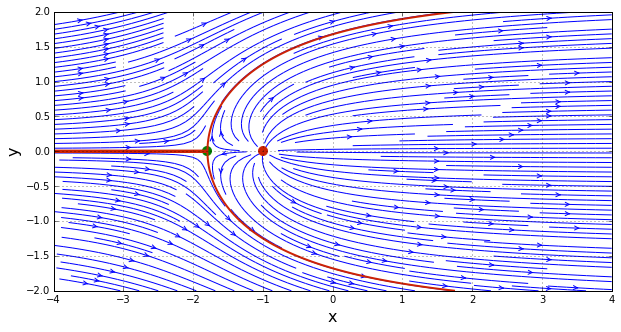

In [9]:
# superposition of the source on the freestream
u = u_freestream + u_source
v = v_freestream + v_source
psi = psi_freestream + psi_source

# plots the streamlines
%matplotlib inline

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.scatter(x_source, y_source, color='#CD2305', s=80, marker='o')

# calculates the stagnation point
x_stagnation = x_source - strength_source/(2*numpy.pi*u_inf)
y_stagnation = y_source

# adding the stagnation point to the figure
pyplot.scatter(x_stagnation, y_stagnation, color='g', s=80, marker='o')

# adds the dividing line to the figure
pyplot.contour(X, Y, psi, 
            levels=[-strength_source/2, +strength_source/2], 
            colors='#CD2305', linewidths=2, linestyles='solid');

What does this look like to you? Drawing attention to the dividing streamline like that makes us imagine a flow coming from the left and turning around to avoid an obstacle, an object that has a curved shape, like the leading edge of an airfoil, perhaps?

If we ignore the flow *inside* the dividing streamline, we can consider that a solid body. In fact, this body has a name: it is called a *Rankine half body*.

##### Challenge question

What is the maximum *width* of the Rankine half body?

**Hint**: Use mass conservation, and think about the flow when $x$ is very large.

## Source-sink pair in a uniform flow

What do you think will happen if we add a sink to our flow pattern? Let's find out! Now we can enjoy the usefulness of our two functions `getVelocity()` and `getStreamfunction()` to create a sink without too much extra coding.

In [10]:
strength_sink = -5.0        # strength of the sink
x_sink, y_sink = 1.0, 0.0   # location of the sink

# computes the velocity field on the mesh grid
u_sink, v_sink = get_velocity(strength_sink, x_sink, y_sink, X, Y)

# computes the stream-function on the grid mesh
psi_sink = get_stream_function(strength_sink, x_sink, y_sink, X, Y)

The superposition of the freestream, the source and the sink is just a simple addition. Look how we are adding all the elements of our two-dimensional arrays, all at the same time. Very pleasant.

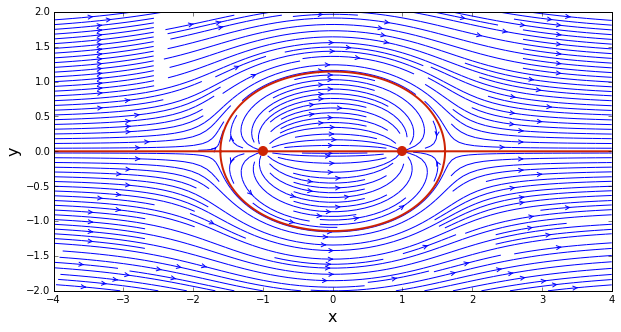

In [11]:
# superposition of a source and a sink on the freestream
u = u_freestream + u_source + u_sink
v = v_freestream + v_source + v_sink
psi = psi_freestream + psi_source + psi_sink

# plots the streamlines
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.scatter([x_source, x_sink], [y_source, y_sink], color='#CD2305', s=80, marker='o')
pyplot.contour(X, Y, psi, levels=[0.], colors='#CD2305', linewidths=2, linestyles='solid');

This looks *very* interesting. It seems like a flow that was going around an egg, doesn't it? In fact, we can can look at the elliptical closed streamline as a solid surface and imagine that this is the flow around an egg-shaped object. It is called a *Rankine oval*.

Now you can play around with the strengths of the source and sink, and see how the flow pattern changes. Be sure to also write your own version of the code separately into a Python script, and run it with different parameters.

##### Challenge question

What is the length and width of the Rankine oval?

### Bernoulli's equation and the pressure coefficient

A very useful measurement of a flow around a body is the *coefficient of pressure* $C_p$. To evaluate the pressure coefficient, we apply *Bernoulli's equation* for an imcompressible flow:

$$p_\infty + \frac{1}{2}\rho V_\infty^2 = p + \frac{1}{2}\rho V^2$$

Do you remember the conditions that apply to this equation? For starters, we can only use it *along* a streamline. Very important.

We define the pressure coefficient in the following way:

$$C_p = \frac{p-p_\infty}{\frac{1}{2}\rho V_\infty^2}$$

i.e.,

$$C_p = 1 - \left(\frac{V}{V_\infty}\right)^2$$

Note that in an incompressible flow, $C_p=1$ at a stagnation point.

We are now going to plot the pressure coefficient throughout the flow field. Think about this for a moment. Where is the pressure maximum? Why?

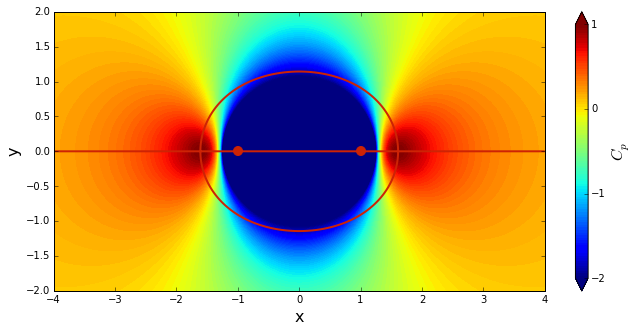

In [12]:
# computes the pressure coefficient field
cp = 1.0 - (u**2+v**2)/u_inf**2

# plots the pressure coefficient field
size = 10
pyplot.figure(figsize=(1.1*size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
pyplot.scatter([x_source, x_sink], [y_source, y_sink], color='#CD2305', s=80, marker='o')
pyplot.contour(X, Y, psi, levels=[0.], colors='#CD2305', linewidths=2, linestyles='solid');

---

##Final words

Study this notebook and try things out here. But at the same time, start writing your own version of the code on a Python editor—and *type* the code instead of copying and pasting, so that you take time to think about what the code means.

In the third lesson of *AeroPython*, you will create a [*doublet*](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/03_Lesson03_doublet.ipynb). Go for it!


---

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()